In [1]:
import torch

import tr_util
import util
from Dimploma.EnvironmentTree import EnvInfo, MatrixEnvInfo
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.utils.my_agent_base import RandomAgent, OptimalAgent
from Dimploma.utils.testingResult import TestResult
from Dimploma.zNetwork.hybrid_gcn import HybridNetworkGlobal
from Dimploma.zNetwork.my_gcn import GCN
from Dimploma.zNetwork.fully_con import FCN

In [2]:
%load_ext autoreload
%autoreload 2

In [99]:
default_path = 'results/min_tree_ppo/node/'
# default_path = 'results/min_tree_ppo/node_cuda/'
# agent_path = '250401_1745#n10_e33_g42_ma_no_ma_2-2_64env_coef'
agent_path = '250403_1706#n20_e142_g42_mn_6-2_big'
# agent_print_name = 'Väčší batch'
agent_print_name = 'Náš agent'
testing_path = f'{default_path}{agent_path}'

maximal = False


compare = True
compare_default_path = 'results/min_tree_ppo/node/'
# compare_default_path = 'results/min_tree_ppo/node_cuda/'
compare_agent_path = '250403_1425#n20_e142_g42_mn_4-2_big'
compare_print_name = 'Najlepší'
# compare_print_name = 'Porovnávací agent'
compare_testing_path = f'{compare_default_path}{compare_agent_path}'

tr_util.load_desc(testing_path)
print('----------------------------------------')
# tr_util.load_desc(compare_testing_path)


Training comment:
Trying to test out matrix repr with fully connected layers

Retrying the best fully con training 250401_1745#n10_e33_g42_ma_no_ma_2-2_64env_coef
changes from that are:
- punish on bad moves


Trying out training with:

Training
Iterations: 1000
Epochs: 4
Batch size: 608
Steps amount: 38
Count of processes: 16
Count of envs: 4
On device: cpu
without early stopping


Network:
Main layers: 6
P layers: 2
V layers: 2
without catenation between layers

Environment:
Class: EnvMinimalTreeTwoStepHeur
Loaded graph from graphs/graph43_n20_e142_heur_rew3.pt
Matrix representation
Node amount: 20
Edge amount: 142
Node features: 2
When graph representation is used
With indexes in nodes

When matrix representation is used
Observation consistt of:

Selected edge info
Selected node info


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.002
Gae_lambda: 0.95
Learning rate: 0.0025

----------------------------------------


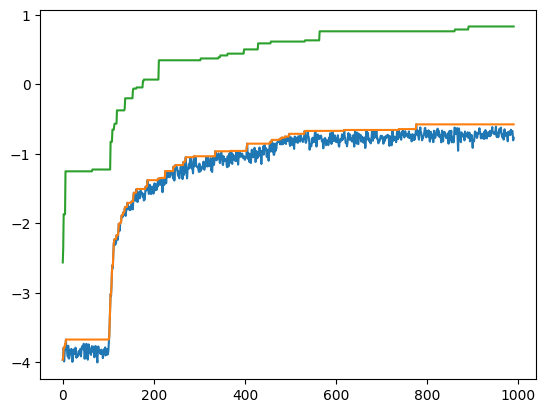

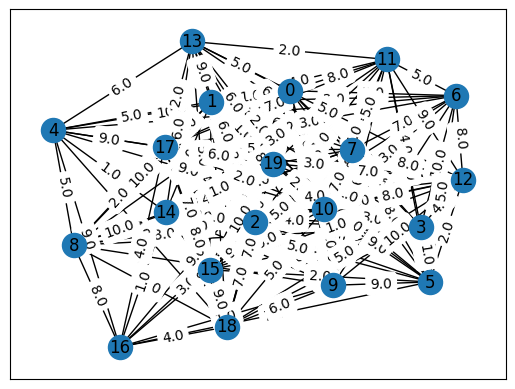

Loading model from results/min_tree_ppo/node/250403_1425#n20_e142_g42_mn_4-2_big/models/iter_999_last.pt


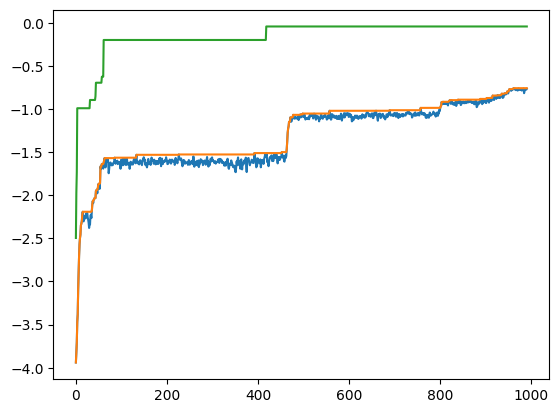

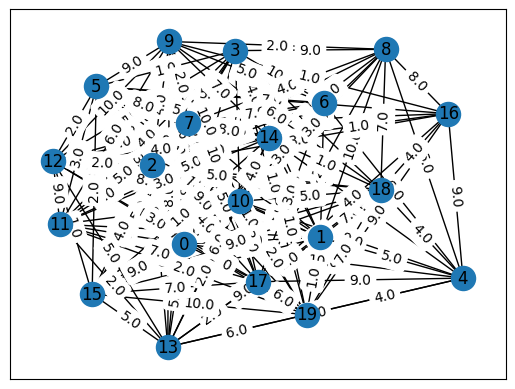

Loading model from results/min_tree_ppo/node/250403_1706#n20_e142_g42_mn_6-2_big/models/iter_999_last.pt


In [100]:

node_amount = 20
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = 142

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iteration_amount = 1000

# Main agent
main_hybrid = False
main_full = True
edge_info = True
node_info = True
step_info = False
adj_matrix = False
node_features = 2  # (index, {0,1} selected or not)
main_layers = 6
main_p_layers = 2
main_v_layers = 2
position = False
remove_index = False
if position:
    node_features += 2
if remove_index:
    node_features -= 1

if main_hybrid:
    main_gcn = HybridNetworkGlobal(node_features, node_amount, remove_index=remove_index, position=position)
    random_gcn = HybridNetworkGlobal(node_features, node_amount, remove_index=remove_index, position=position)
elif main_full:
    main_gcn = FCN(node_amount, node_features, edge_amount, main_layers, main_p_layers, main_v_layers, edge_info, node_info, step_info, adj_matrix)
    random_gcn = FCN(node_amount, node_features, edge_amount, main_layers, main_p_layers, main_v_layers, edge_info, node_info, step_info, adj_matrix)
else:
    main_gcn = GCN(node_amount, node_features, cat=False, conv_layers=main_layers, conv_p_layers=main_p_layers, linear_layers=main_v_layers, remove_index=remove_index, position=position)
    random_gcn = GCN(node_amount, node_features, cat=False, conv_layers=main_layers, conv_p_layers=main_p_layers, linear_layers=main_v_layers, remove_index=remove_index, position=position)



graph_provider = GraphProvider(fixed_graph=None, device=device, nodes=node_amount, edges=edge_amount, position=position)

env_info = EnvInfo(graph_provider)
if main_full:
    env_info = MatrixEnvInfo(graph_provider, edge_info, node_info, step_info, adj_matrix)

# Comparing agent
if compare:
    compare_hybrid = False
    compare_full = True
    compare_node_features = 2  # (index, {0,1} selected or not)
    compare_position = False
    compare_remove_index = False
    compare_layers = 4
    compare_p_layers = 2
    compare_v_layers = 2
    if compare_position:
        compare_node_features += 2
    if compare_remove_index:
        compare_node_features -= 1

    if compare_hybrid:
        compare_gcn = HybridNetworkGlobal(compare_node_features, node_amount, remove_index=compare_remove_index, position=compare_position)
    elif main_full:
        compare_gcn = FCN(node_amount, node_features, edge_amount, compare_layers, compare_p_layers, compare_v_layers, edge_info, node_info, step_info, adj_matrix)
    else:
        compare_gcn = GCN(node_amount, compare_node_features, cat=False, conv_layers=compare_layers, conv_p_layers=compare_p_layers, linear_layers=compare_v_layers, remove_index=compare_remove_index, position=compare_position)
    compare_graph, _, compare_agent_test = tr_util.load_agent_for_testing(compare_testing_path, iteration_amount, env_info, compare_gcn, device)



loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(testing_path, iteration_amount, env_info, main_gcn, device, maximal)

In [101]:
test_amount = 100
pretty_print = True
print_rews = False

tests = TestResult(node_amount, test_amount)

#random agents
random_uniform = RandomAgent()

random_net = Agent(model=random_gcn, device=device, name="random_test", override=True, test=True)

tests.addAgent(agent_print_name, agent_test, 'orange')
if compare:
    # noinspection PyUnboundLocalVariable
    tests.addAgent(compare_print_name, compare_agent_test, 'yellow')
tests.addAgent('Optimum' if pretty_print else 'Optimal', OptimalAgent(), 'green')
tests.addAgent('Náhodný výber' if pretty_print else 'Random uniform', random_uniform, 'red', multiple_tetst=True)
tests.addAgent('Náhodná sieť' if pretty_print else 'Random network', random_net)


Náš agent
Priemer, Min, Max: 59.00
Najlepší
Priemer, Min, Max: 60.00
Optimum
Priemer, Min, Max: 23.00
Náhodný výber
Priemer: 100.90, Min: 72.00, Max: 129.00
Náhodná sieť
Priemer, Min, Max: 99.00


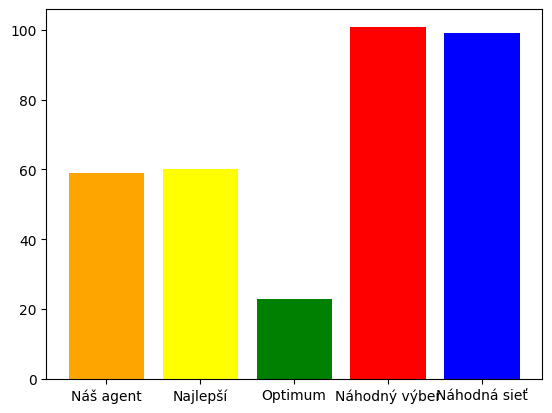

In [102]:
tests.test(test_env)
if pretty_print:
    tests.print_result_pretty()
else:
    tests.print_result(print_rews)
# print(f'Optimal: {test_env.calculate_min_span_tree()}')

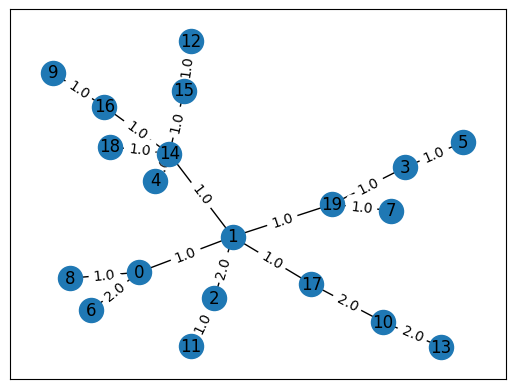

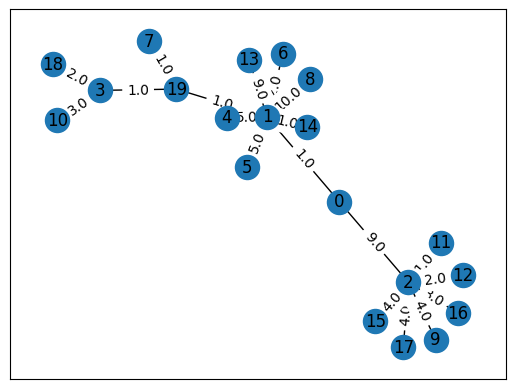

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -0.9565217391304346],
 [19,
  3,
  0,
  1,
  0,
  2,
  19,
  7,
  2,
  11,
  3,
  18,
  3,
  10,
  1,
  19,
  1,
  4,
  1,
  5,
  1,
  6,
  1,
  8,
  1,
  13,
  1,
  14,
 

In [79]:
_, a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [94]:
node_sums = util.get_node_sums(loaded_graph)
degrees = util.get_out_edges(loaded_graph)

print(f'Node sum max: {node_sums.max()}')
print(f'Node sum min: {node_sums.min()}')
print(f'Degree max: {degrees.max()}')
print(f'Degree min: {degrees.min()}')

torch.stack([loaded_graph.x[:, 0], node_sums.T, degrees.T])

Node sum max: 10.300000190734863
Node sum min: 5.5
Degree max: 18.0
Degree min: 10.0


tensor([[ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
          8.0000,  9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
         16.0000, 17.0000, 18.0000, 19.0000],
        [ 8.9000,  7.7000,  9.5000,  7.3000,  6.8000,  7.3000,  6.4000, 10.3000,
          6.9000,  8.8000,  9.7000,  6.3000,  7.6000,  6.8000,  6.7000,  7.4000,
          5.5000,  7.8000,  8.1000,  6.6000],
        [15.0000, 16.0000, 17.0000, 14.0000, 11.0000, 14.0000, 12.0000, 17.0000,
         12.0000, 14.0000, 18.0000, 14.0000, 14.0000, 13.0000, 16.0000, 13.0000,
         10.0000, 16.0000, 14.0000, 14.0000]])

In [ ]:
torch.cat([loaded_graph.edge_index.T, loaded_graph.edge_attr], dim=1)

In [89]:
loaded_graph.x[:, 0]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])